# Stocker les données avec Elastic Search

## Imports

In [1]:
import pandas as pd	
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from faker import Faker
from elasticsearch import Elasticsearch
import requests
import pickle
from elasticsearch import Elasticsearch
from faker import Faker
import csv
import sys
sys.path.append('../Partie_1_Analyse')

## 1. Mise en place

Après avoir installé l'extension Docker dans VS Code et s'être connecté, on suit les étapes suivantes

### 1.1 Démarrer un container

à partir de l’image docker.elastic.co/elasticsearch/elasticsearch:7.17.10  
- en mode détaché -d
- monter le volume /usr/share/elasticsearch/data en local
- utiliser le mapping de port -p 9200:9200
- utiliser la variable -e "discovery.type=single-node"
- le nom du container sera --name elastic

Dans le répertoire de travail, dans un terminal, entrez la commande ci-dessous :

`docker run -d -p 9200:9200 -e "discovery.type=single-node" -v /home/apprenant/Documents/DevIA/Projet_DevIA/NLP_Project:/usr/share/elasticsearch/data --name elastic docker.elastic.co/elasticsearch/elasticsearch:7.17.10`

docker run -d -p 9200:9200 -e "discovery.type=single-node" -v $(pwd)/data:/usr/share/elasticsearch/data --name elastic docker.elastic.co/elasticsearch/elasticsearch:7.17.10 

### 1.4 Visualiser les logs du container  

Dans le terminal, entrez la commande suivante :

`docker logs elastic`

### 1.3 Appeler la route racine “/” 

Dans le terminal, entrez la commande suivante :

`curl http://localhost:9200/`

## 2. Mapper et importer les données

Pour voir le status des index crées, il faut se rednre à l'URL suivante : http://localhost:9200/_cat/indices

### 2.1 Poster le mapping d’un index nommé “notes”

Il doit contenir :  

- un champ “patient_lastname” qui est un term
- un champ “patient_firstname” qui est un term
- un champ “text”, texte analysé en standard
- un champ “date”, qui est une date
- un champ “patient_left”, qui est un booléen
- un champ “emotion”, qui est un term
- un champ ‘confidence” qui est un float  

Pour poster le mapping de l'index "notes" avec les champs spécifiés dans Elasticsearch, on utilise l'API REST d'Elasticsearch avec cURL :  

Le conteneur Elasticsearch crée à l'étape précédente doit être en cours d'exécution.  

Dans un terminal, il faut entrer la commande suivante pour poster le mapping de l'index "notes" :  

```
curl -X PUT "http://localhost:9200/notes" -H 'Content-Type: application/json' -d '
{
  "mappings": {
    "properties": {
      "patient_lastname": {
        "type": "keyword"
      },
      "patient_firstname": {
        "type": "keyword"
      },
      "text": {
        "type": "text",
        "analyzer": "standard"
      },
      "date": {
        "type": "date"
      },
      "patient_left": {
        "type": "boolean"
      },
      "emotion": {
        "type": "keyword"
      },
      "confidence": {
        "type": "float"
      }
    }
  }
}'
```

Cette commande envoie une requête PUT à l'URL http://localhost:9200/notes pour créer l'index "notes" avec le mapping spécifié. Chaque champ est défini avec son type approprié.

### 2.2 Alimenter l’index “notes” à l’aide du jeu de données et de la librairie Faker. 

In [3]:
# # Créer une instance de Faker
# fake = Faker()

# # Créer une instance d'Elasticsearch
# es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])

# # Générer des données et les indexer dans l'index "notes"
# for _ in range(100):
#     note = {
#         "patient_lastname": fake.last_name(),
#         "patient_firstname": fake.first_name(),
#         "text": fake.text(),
#         "date": fake.date_time_this_decade(),
#         "patient_left": fake.boolean(),
#         "emotion": fake.word(),
#         "confidence": fake.pyfloat(left_digits=2, right_digits=2)
#     }
#     es.index(index="notes", document=note)


Ce code utilise la librairie Faker pour générer des valeurs aléatoires pour chaque champ, puis il utilise le client Elasticsearch pour indexer les données dans l'index "notes". Vous pouvez ajuster le nombre de documents générés en modifiant la valeur de range(100) selon vos besoins.

Les notes générées sont accessibles à l'URL suivante : http://localhost:9200/notes/_search  

Pour accèder aux nombres de notes dans la BDD : http://localhost:9200/notes/_count

Exemple de "fakes" notes générées : 

In [11]:
# Créer une instance d'Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])

# Effectuer une requête pour récupérer les notes
result = es.search(index="notes", size=2)  # Récupère les 2 premiers documents, ajustez la taille selon vos besoins

# Parcourir les résultats et afficher les notes
for hit in result['hits']['hits']:
    note = hit['_source']
    print("Patient Last Name:", note['patient_lastname'])
    print("Patient First Name:", note['patient_firstname'])
    print("Text:", note['text'])
    print("Date:", note['date'])
    print("Patient Left:", note['patient_left'])
    print("Emotion:", note['emotion'])
    print("Confidence:", note['confidence'])
    print("-------------------------")

Patient Last Name: Brennan
Patient First Name: Desiree
Text: i think it s the easiest time of year to feel dissatisfied
Date: 2021-05-09
Patient Left: False
Emotion: anger
Confidence: 0.7602833430034607
-------------------------
Patient Last Name: Williams
Patient First Name: Amy
Text: i feel low energy i m just thirsty
Date: 2018-05-03
Patient Left: True
Emotion: sadness
Confidence: 0.7001218895333582
-------------------------


### 2.3 Mettez en place un pipeline utilisant le modèle TF-IDF que vous avez développé avec scikit-learn pour remplir les champs “emotion” et “confidence”

La classe **TextProcessor** est définie dans *preprocessing.py*, puis le pipeline est mis en place dans le fichier *tf-idf.py*, on obient alors le fichier pickle *nlp-pipeline.pkl* que l'on va importer et utiliser pour remplir les champs "emotion" et "confidence".

On remplis les champs de l'index comme suit :   
"patient_lastname" : Faker  
"patient_firstname" : Faker  
"text": CSV  
"date" : Faker  
"patient_left" : Faker  
"emotion" : Model  
"confidence" : Model  


In [14]:
# Charger le pipeline pré-entraîné
with open('../Partie_1_Analyse/pipeline/nlp-pipeline-linearsvc.pkl', 'rb') as f:
    pipeline = pickle.load(f)

# Connexion à Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])

# Instanciation de Faker
fake = Faker()

# Liste de patients
patients = []
for _ in range(200):
    patients.append((fake.last_name(), fake.first_name()))

# Chemin vers le fichier CSV
csv_file = '../Partie_1_Analyse/data/Emotion_final.csv'

# Lecture du fichier CSV et indexation des données
with open(csv_file, 'r') as file:
    reader = csv.DictReader(file)
    for i, row in enumerate(reader):
        # Sélectionner le texte de la ligne
        text = row['Text']

        # Prétraitement, vectorisation et prédiction avec le pipeline
        emotion = pipeline.predict([text])[0]
        decision = pipeline.decision_function([text])[0]
        confidence = max(1 / (1 + np.exp(-decision)))

        # Sélectionner le patient correspondant
        patient_lastname, patient_firstname = patients[i % len(patients)]

        # Créer le document à indexer
        doc = {
            'patient_lastname': patient_lastname,
            'patient_firstname': patient_firstname,
            'text': text,
            'date': fake.date(),
            'patient_left': fake.boolean(),
            'emotion': emotion,
            'confidence': confidence
        }

        # Indexation du document dans Elasticsearch
        es.index(index='notes', body=doc)

print("Indexation terminée.")


## 3. Requêtes

### 3.1 En recherchant dans la base elastic search, aboutissez à un data frame permettant d’afficher la répartition des sentiments des textes pour un patient (nom/prénom)

In [87]:
from elasticsearch import Elasticsearch
import pandas as pd

def distribution_sentiment(es, patient_firstname, patient_lastname):
    query = {
            "size": 10,
            "query": {
                "bool": {
                    "must": [
                        {"term": {"patient_firstname": patient_firstname}},
                        {"term": {"patient_lastname": patient_lastname}}
                    ]
                }
            },
            "aggs": {
                "sentiment_distribution": {
                    "terms": {"field": "emotion"}
                }
            }
        }

    response = es.search(index="notes", body=query)
    buckets = response["aggregations"]["sentiment_distribution"]["buckets"]

    # Création du DataFrame
    df = pd.DataFrame(buckets, columns=["key", "doc_count"])
    total_count = df["doc_count"].sum()
    
    # Calcul des pourcentages
    df["Percentage"] = (df["doc_count"] / total_count) * 100

    return df

# Exemple d'utilisation
distribution_sentiment(es, "Laura", "Wright")


,key,doc_count,Percentage
0,sadness,38,35.185185
1,happy,29,26.851852
2,anger,21,19.444444
3,fear,10,9.259259
4,love,6,5.555556
5,surprise,4,3.703704


### 3.2  Élaborez une matrice de sentiments contradictoire (toujours en utilisant la base elastic search.    

On veut savoir parmi les documents classifiés comme *happy*, quel pourcentage contient le mot *sadness*. Puis quel pourcentage contient *fear*, etc.  Et cela, pour tous les sentiments.  
On représente les résultats dans une HeatMap  

In [126]:
def compter_doc_sentiment(es,emotion):
    query = {
        "size": 0,
        "query": {
            "terms": {
                "emotion": [emotion]
            }
        }
    }
   
    response = es.search(index="notes", body=query)

    return response["hits"]["total"]["value"]


def compter_doc_sentiment_et_mot(es,emotion,emotion_word):
    query = {
        "size": 0,
        "query": {
            "terms": {
                "emotion": [emotion]
            }
        },
        "post_filter": {
            "match": {
                "text": emotion_word
            }
        }
    }

    
    response = es.search(index="notes", body=query)

    return response["hits"]["total"]["value"]



print(compter_doc_sentiment(es,'happy'))
compter_doc_sentiment_et_mot(es,'happy', 'happy')

7157


204

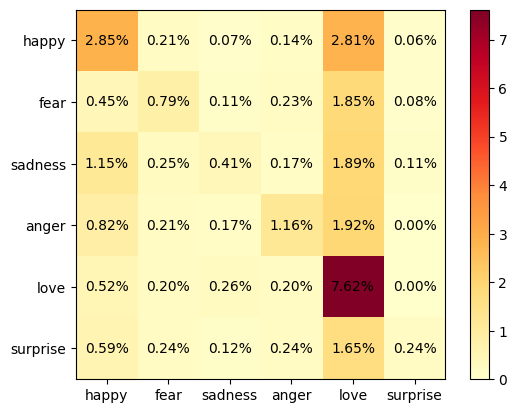

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Liste des sentiments
sentiments = ['happy', 'fear', 'sadness', 'anger', 'love', 'surprise']

# Matrice de contradiction
contradiction_matrix = np.zeros((len(sentiments), len(sentiments)))

# Boucle pour chaque sentiment
for i in range(len(sentiments)):
    for j in range(len(sentiments)):
        # Compter le nombre de documents avec le sentiment i et le mot j
        count = compter_doc_sentiment_et_mot(es, sentiments[i], sentiments[j])
        
        # Calculer le pourcentage
        total_count = compter_doc_sentiment(es, sentiments[i])
        percentage = (count / total_count) * 100
        
        # Stocker le pourcentage dans la matrice de contradiction
        contradiction_matrix[i][j] = percentage

# Création de la HeatMap
fig, ax = plt.subplots()
heatmap = ax.imshow(contradiction_matrix, cmap='YlOrRd')

ax.set_xticks(np.arange(len(sentiments)))
ax.set_yticks(np.arange(len(sentiments)))
ax.set_xticklabels(sentiments)
ax.set_yticklabels(sentiments)

# Ajouter les valeurs sur la HeatMap
for i in range(len(sentiments)):
    for j in range(len(sentiments)):
        text = ax.text(j, i, "{:.2f}%".format(contradiction_matrix[i, j]), ha="center", va="center", color="black")

plt.colorbar(heatmap)
plt.show()


### 3.3. Pour chacune des étapes du deuil (denial, anger, bargaining, depression, and acceptance) rechercher le nombre de text correspondants

à l’aide:  
- d’une recherche pleine  
- d’une fuzzy recherche.  

In [100]:
# Étapes du deuil
stages_of_grief = ['denial', 'anger', 'bargaining', 'depression', 'acceptance']

# Boucle pour chaque étape
for stage in stages_of_grief:
    # Requête de correspondance pour l'étape spécifique
    query = {
        "query": {
            "match": {
                "text": stage
            }
        }
    }

    # Exécution de la requête
    response = es.search(index='notes', body=query)

    # Récupération du nombre de documents correspondants
    num_documents = response['hits']['total']['value']

    # Affichage du résultat
    print("Nombre de textes pour l'étape", stage, ":", num_documents)


Nombre de textes pour l'étape denial : 2
Nombre de textes pour l'étape anger : 66
Nombre de textes pour l'étape bargaining : 0
Nombre de textes pour l'étape depression : 23
Nombre de textes pour l'étape acceptance : 9


**Recherche approximative**   
Le paramètre de recherche "fuzzy" dans Elasticsearch permet d'effectuer une recherche approximative (ou floue) basée sur la similarité entre les termes.   
En utilisant cette requête, Elasticsearch va rechercher dans le champ spécifié ("text") des termes qui sont similaires au terme donné ("denial"). La similarité sera déterminée en utilisant l'**algorithme de correspondance floue de Levenshtein** (par défaut) ou tout autre algorithme configuré.
Cet alogirthme fonctionne de la manière suivante :  
On donne 2 mots, pour chaque paire de caractères, l'algorithme détermine si les caractères sont identiques ou différents, chaque opération d'insertion, substitution ou suppression ajoute un couût de 1 à la distance d'édition. À la fin, **la distance d'édition est le nombre total d'opérations de substitution, d'insertion et de suppression effectuées pour transformer une chaîne en une autre**.  
Par défaut sur Elasticsearch, elle est fixée à 2.

In [101]:
# Boucle pour chaque étape
for stage in stages_of_grief:
    query = {
        "query": {
            "fuzzy": {
                "text": stage
            }
        }
    }

    # Exécution de la requête
    response = es.search(index='notes', body=query)

    # Récupération du nombre de documents correspondants
    num_documents = response['hits']['total']['value']

    # Affichage du résultat
    print("Nombre de textes pour l'étape", stage, ":", num_documents)


Nombre de textes pour l'étape denial : 119
Nombre de textes pour l'étape anger : 82
Nombre de textes pour l'étape bargaining : 0
Nombre de textes pour l'étape depression : 84
Nombre de textes pour l'étape acceptance : 71


### 3.4 Rechercher les textes

- qui doivent matcher l’expression “good day” (must)  
- chez les patients encore en consultation (filter)  
- qui contiennent si possible “to rest” (should)  
- qui ne doivent pas avoir seuil de confiance inférieur à 0.6 s’il existe.   
- Observer la répartition de ces résultats par sentiment  

In [13]:
query = {
  "query": {
    "bool": {
      "must": [
        {
          "match": {"text": "good day"}
        }
      ],
      "should": [
        {
          "match": {"text": "to rest"}
        }
      ], 
      "filter": [
        {
          "term": {"patient_left": False}
        },
        {
          "range": {"confidence": {"gte": 0.6}}
        }
      ]
    }
  }
}

response = es.search(index='notes', body=query)


# Récupérer les hits (documents) de la réponse
hits = response['hits']['hits']

# Parcourir les documents et afficher les informations pertinentes
for hit in hits:
    # Récupérer les champs du document
    doc_id = hit['_id']
    note = hit['_source']

    # Afficher les informations du document
    print("Document ID:", doc_id)
    print("Text:", note['text'])
    print("Patient Last Name:", note['patient_lastname'])
    print("Patient First Name:", note['patient_firstname'])
    print("Date:", note['date'])
    print("Patient Left:", note['patient_left'])
    print("Emotion:", note['emotion'])
    print("Confidence:", note['confidence'])
    print("----------------------------------")


Document ID: HYoyJ4kBgQK_72RqA4Tz
Text: i end up feeling exhausted for all the rest of the day
Patient Last Name: Roberson
Patient First Name: Beth
Date: 1977-04-11
Patient Left: False
Emotion: sadness
Confidence: 0.7635605799622162
----------------------------------
Document ID: 4YowJ4kBgQK_72RqYn0j
Text: i either feel like crap about myself all day and try to make up for it the rest of the day and am exhausted
Patient Last Name: Ayers
Patient First Name: Jacqueline
Date: 1998-09-19
Patient Left: False
Emotion: sadness
Confidence: 0.6623424444063446
----------------------------------
Document ID: 64o1J4kBgQK_72Rqp5F6
Text: i end up feeling groggy the rest of the day amp guilty that i didnt get anything done
Patient Last Name: Griffin
Patient First Name: Brittany
Date: 1998-06-28
Patient Left: False
Emotion: sadness
Confidence: 0.9112498534121478
----------------------------------
Document ID: 04ovJ4kBgQK_72RqUHlo
Text: ive had where i feel good enough to work the whole shift possibly 

## Effacer la BDD

In [13]:
# index = 'notes'  # Remplacez par le nom de votre index

# # URL de l'API de suppression des documents
# url = f'http://localhost:9200/{index}/_delete_by_query'

# # Corps de la requête de suppression
# query = {
#     "query": {
#         "match_all": {}
#     }
# }

# # Envoyer la requête de suppression
# response = requests.post(url, json=query)

# # Vérifier la réponse
# if response.status_code == 200:
#     print("Les documents ont été supprimés avec succès.")
# else:
#     print("Une erreur s'est produite lors de la suppression des documents.")
#     print(response.text)

Les documents ont été supprimés avec succès.


## Effacer l'index "notes"

In [124]:
# from elasticsearch import Elasticsearch

# # Connexion à Elasticsearch
# es = Elasticsearch(hosts=['http://localhost:9200'])

# # Suppression de l'index "notes"
# index_name = "notes"
# response = es.indices.delete(index=index_name)

# # Vérification de la réponse
# if response['acknowledged']:
#     print(f"L'index '{index_name}' a été supprimé avec succès.")
# else:
#     print(f"Erreur lors de la suppression de l'index '{index_name}'.")